# ESRB Rating Classification

Coded by Luna McBride

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt #Plotting
%matplotlib inline

plt.rcParams["figure.figsize"] = (10,10) #Make the plots bigger by default
plt.rcParams["lines.linewidth"] = 2 #Setting the default line width
plt.style.use("ggplot") #Define the style of the plot

from sklearn.model_selection import train_test_split #Split the data into train and test
from sklearn.ensemble import RandomForestClassifier #Forest for prediction and regression
from sklearn.metrics import mean_squared_error #Error testing
from sklearn.metrics import classification_report #Report of Classification

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/video-games-rating-by-esrb/test_esrb.csv
/kaggle/input/video-games-rating-by-esrb/Video_games_esrb_rating.csv


In [2]:
esrbTrain = pd.read_csv("../input/video-games-rating-by-esrb/Video_games_esrb_rating.csv") #Load the training data
esrbTest = pd.read_csv("../input/video-games-rating-by-esrb/test_esrb.csv") #Load the testing data

esrbTrain.head() #Take a peek at the training data

,title,console,alcohol_reference,animated_blood,blood,blood_and_gore,cartoon_violence,crude_humor,drug_reference,fantasy_violence,...,sexual_content,sexual_themes,simulated_gambling,strong_janguage,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence,esrb_rating
0,Monster Jam Steel Titans 2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E
1,Subnautica: Below Zero,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ET
2,NIER REPLICANT VER.1.22474487139…,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,M
3,Jamestown+,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,ET
4,Neptunia Virtual Stars,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,T


---

# Check for Null Values

In [3]:
print(esrbTrain.isnull().any()) #Check for null values in the training set

title                       False
console                     False
alcohol_reference           False
animated_blood              False
blood                       False
blood_and_gore              False
cartoon_violence            False
crude_humor                 False
drug_reference              False
fantasy_violence            False
intense_violence            False
language                    False
lyrics                      False
mature_humor                False
mild_blood                  False
mild_cartoon_violence       False
mild_fantasy_violence       False
mild_language               False
mild_lyrics                 False
mild_suggestive_themes      False
mild_violence               False
no_descriptors              False
nudity                      False
partial_nudity              False
sexual_content              False
sexual_themes               False
simulated_gambling          False
strong_janguage             False
strong_sexual_content       False
suggestive_the

In [4]:
print(esrbTest.isnull().any()) #Check for null values in the testing set

title                       False
console                     False
alcohol_reference           False
animated_blood              False
blood                       False
blood_and_gore              False
cartoon_violence            False
crude_humor                 False
drug_reference              False
fantasy_violence            False
intense_violence            False
language                    False
lyrics                      False
mature_humor                False
mild_blood                  False
mild_cartoon_violence       False
mild_fantasy_violence       False
mild_language               False
mild_lyrics                 False
mild_suggestive_themes      False
mild_violence               False
no_descriptors              False
nudity                      False
partial_nudity              False
sexual_content              False
sexual_themes               False
simulated_gambling          False
strong_janguage             False
strong_sexual_content       False
suggestive_the

There are no null values in either dataset.

---

# Data Exploration

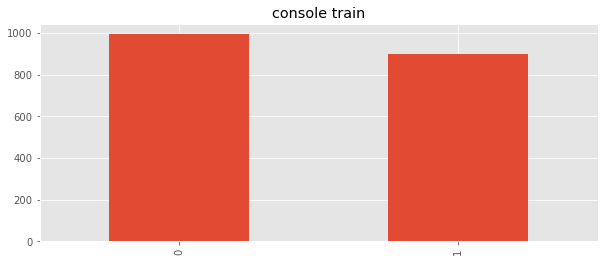

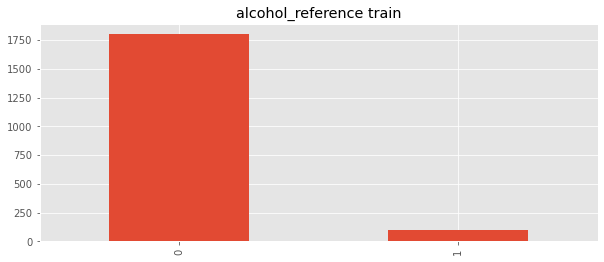

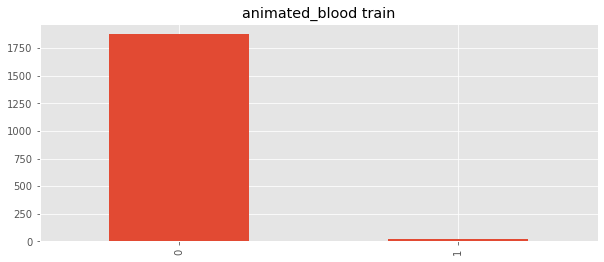

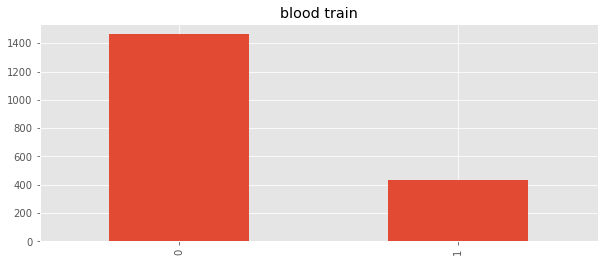

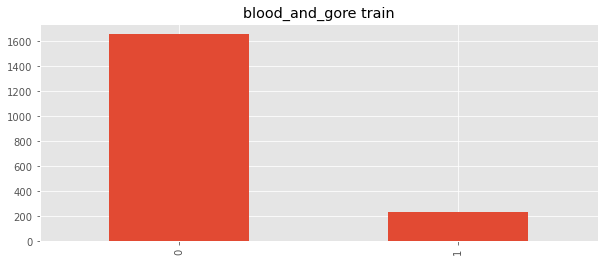

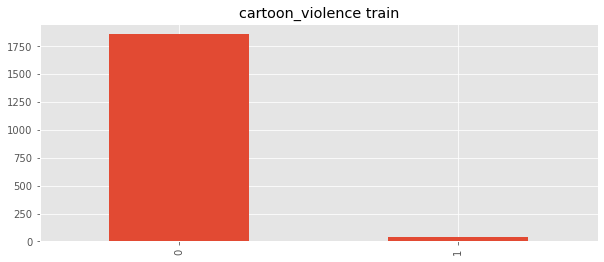

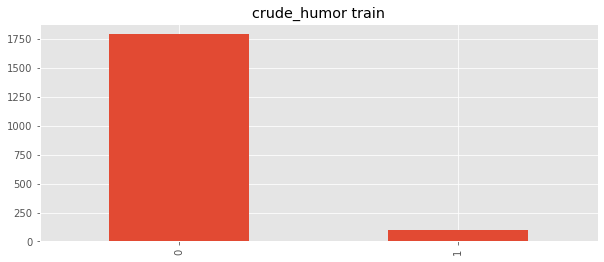

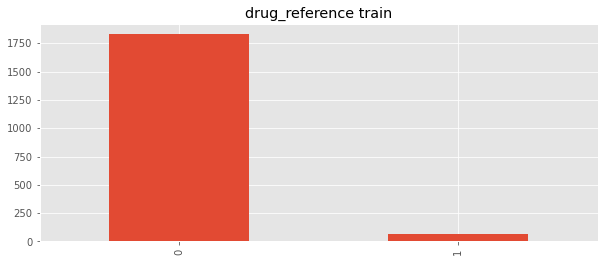

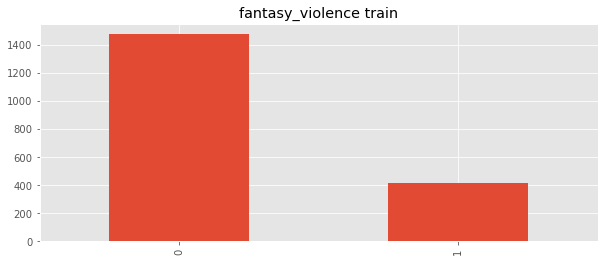

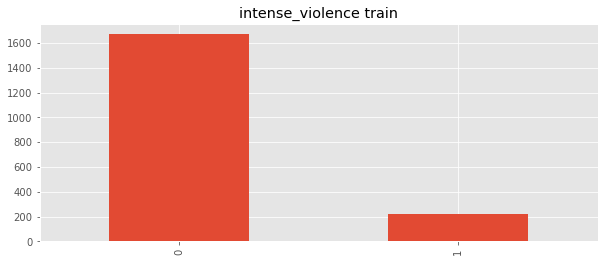

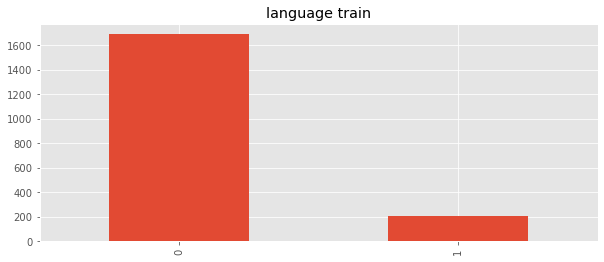

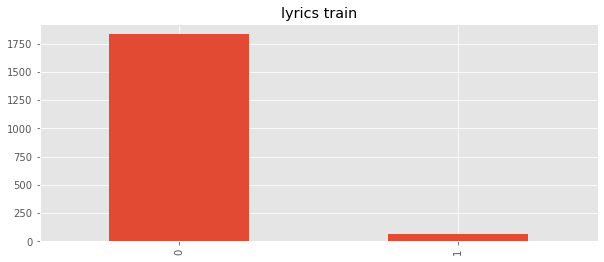

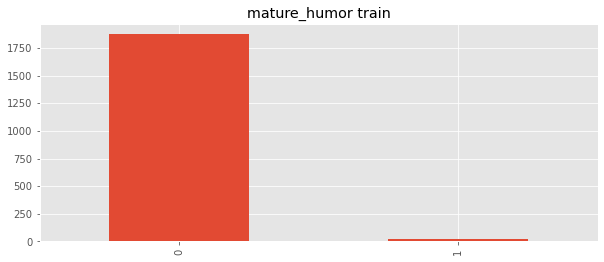

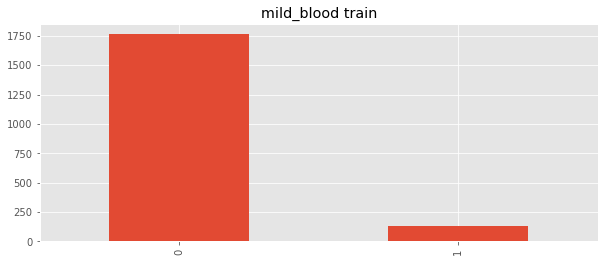

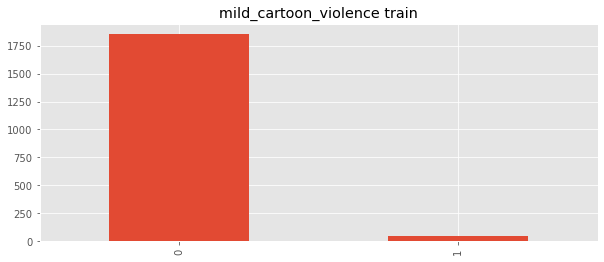

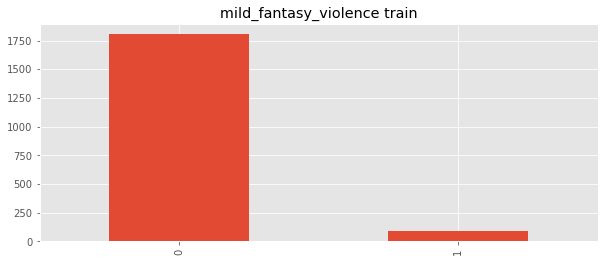

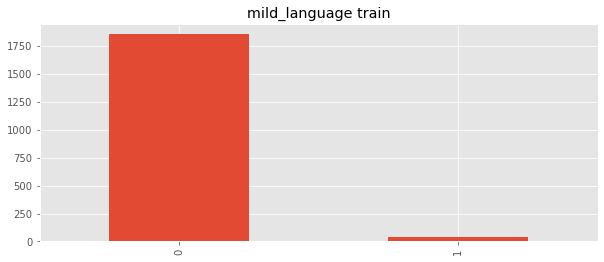

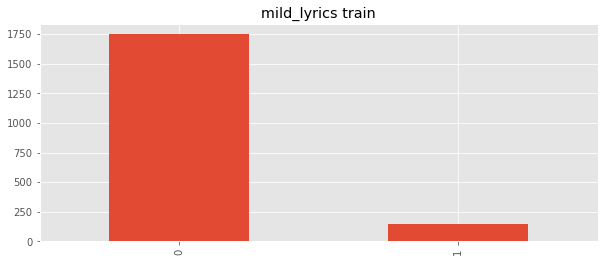

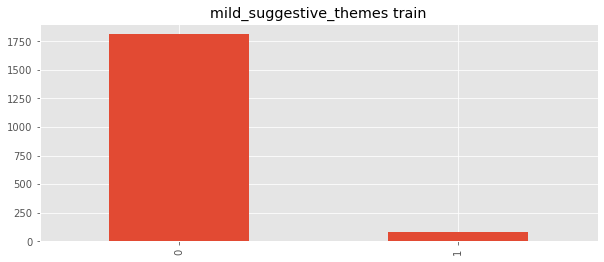

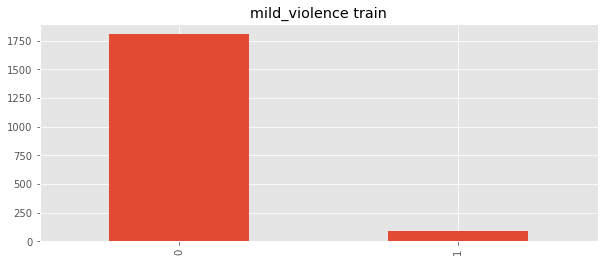

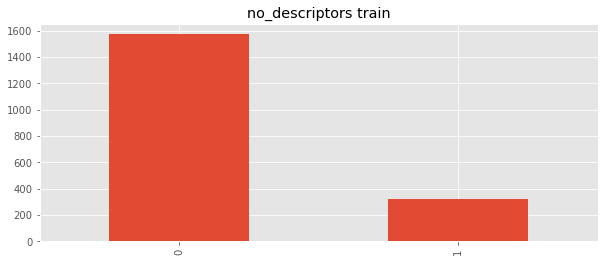

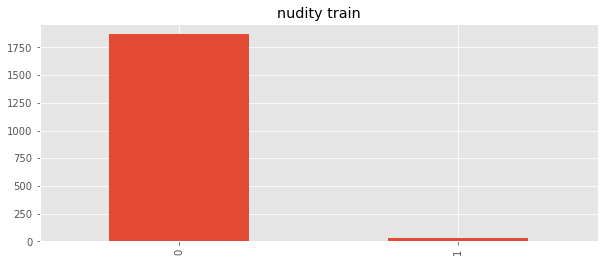

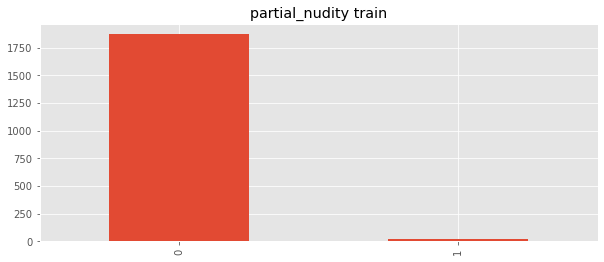

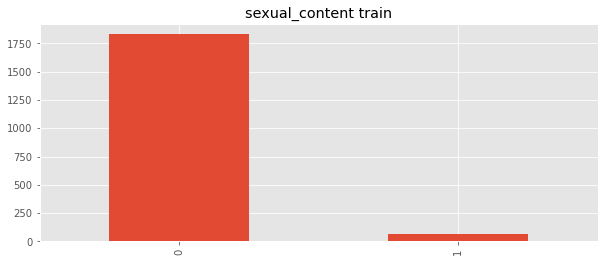

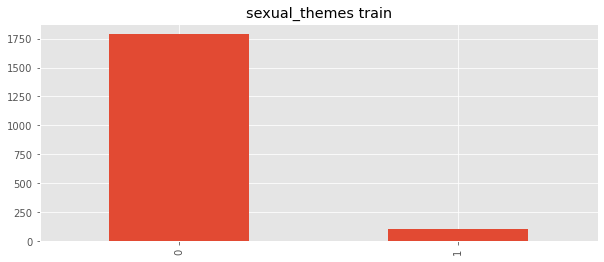

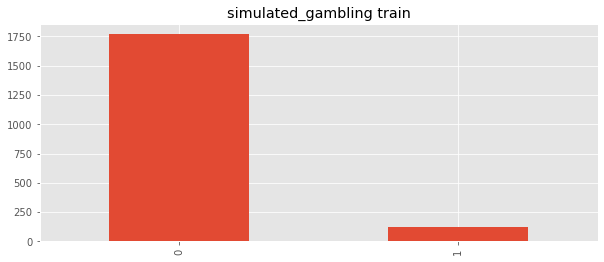

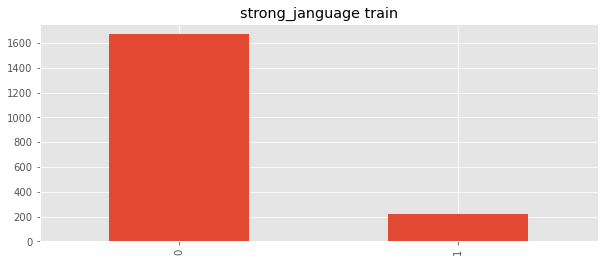

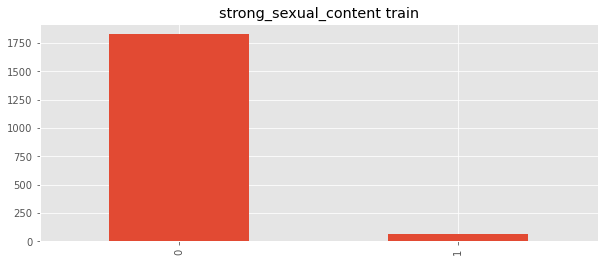

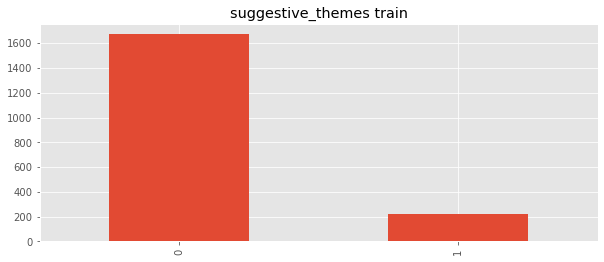

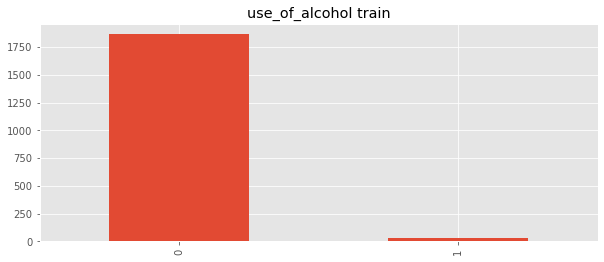

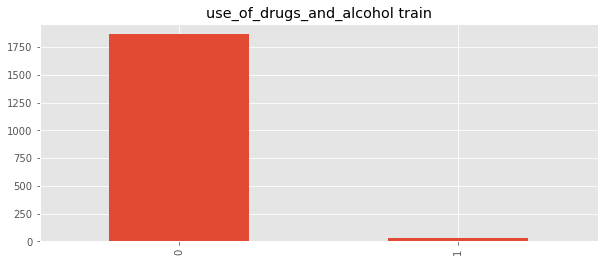

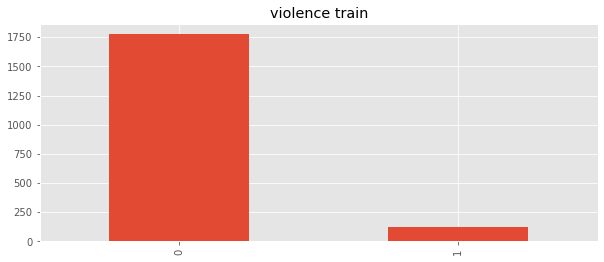

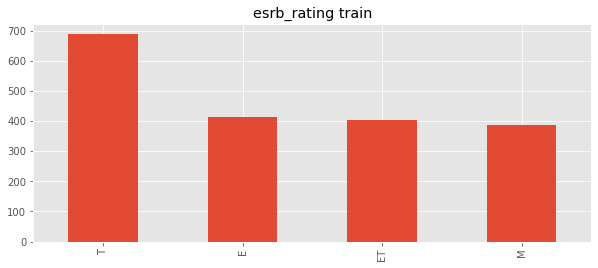

In [5]:
colTrain = esrbTrain.columns #Load the training set's columns
plt.rcParams["figure.figsize"] = (10,4) #Change the plot size
plt.rcParams.update({'figure.max_open_warning': 0}) #Stop the warning from appearing, since there are 20+ columns

#For each column, plot the values for a quick visualization
for col in colTrain:
    #Ignore the title column
    if col != "title":
        plt.figure() #Reload the figure to have items on separate plots
        esrbTrain[col].value_counts().plot.bar(title = col + " train") #Plot the columns

This dataset is heavily weighted toward more age appropriate descriptors (or rather no violence, no blood, etc). This could make the model have more difficulty in making predictions.

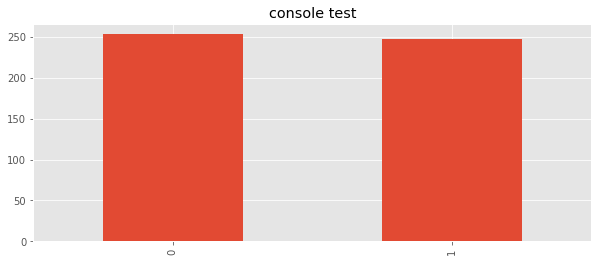

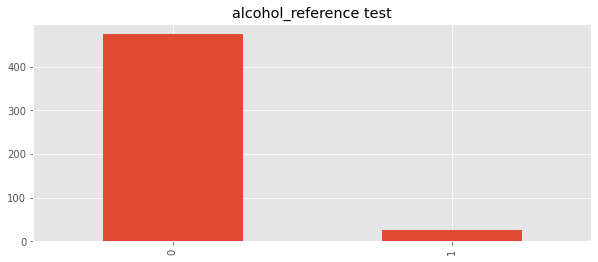

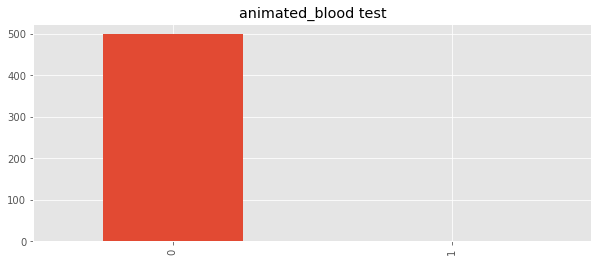

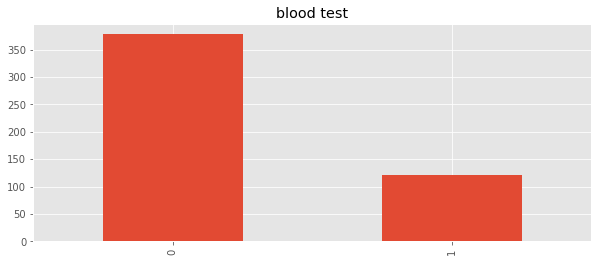

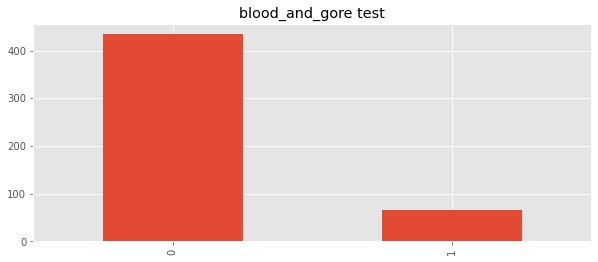

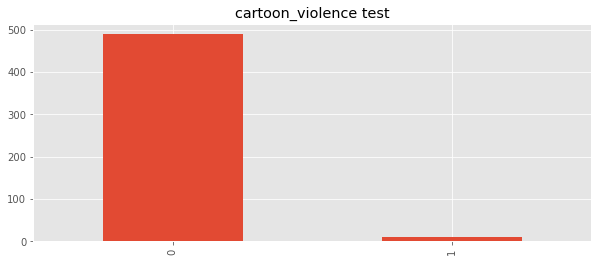

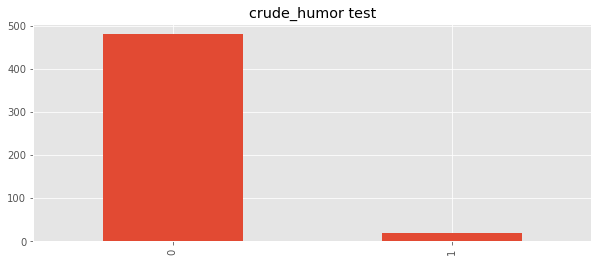

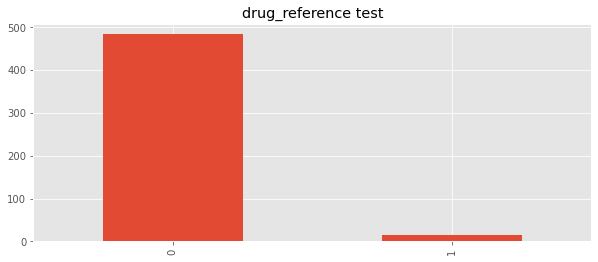

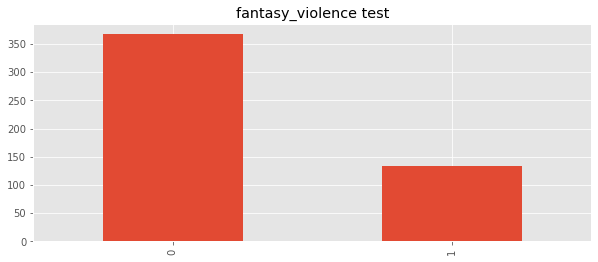

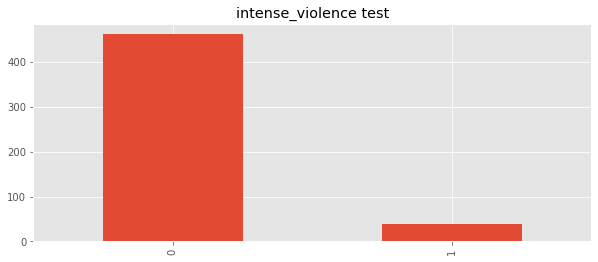

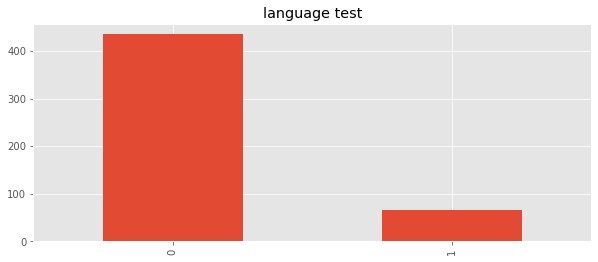

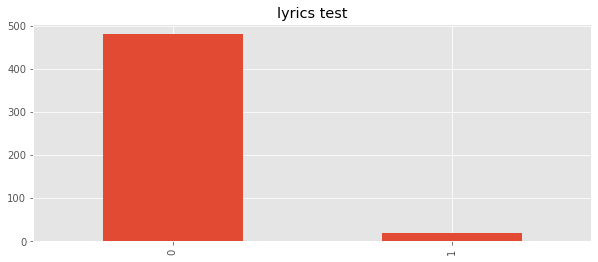

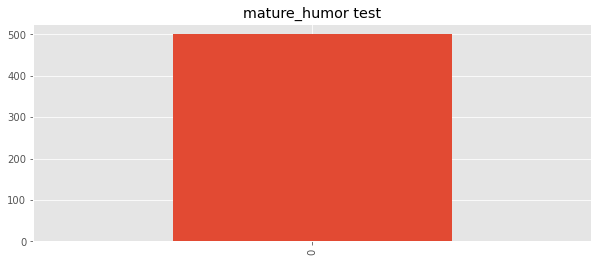

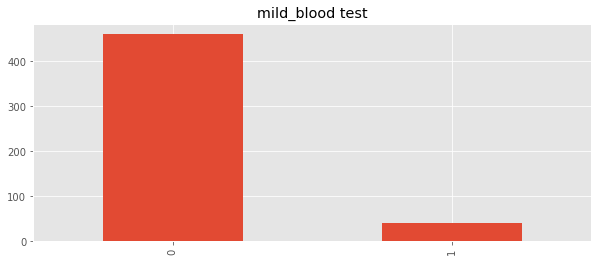

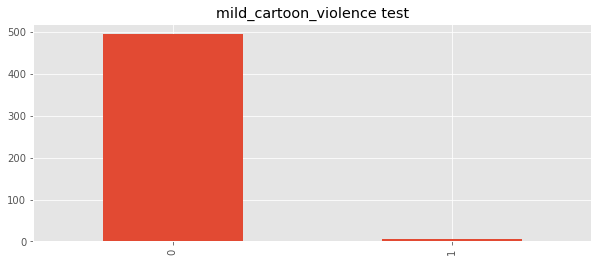

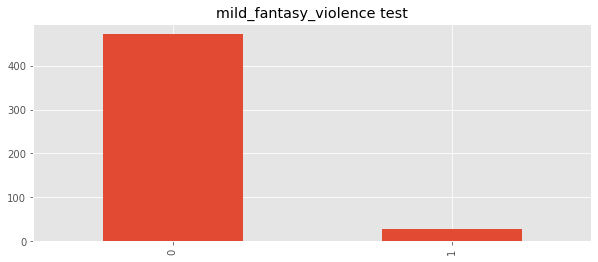

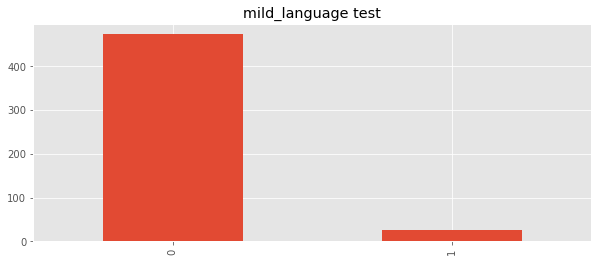

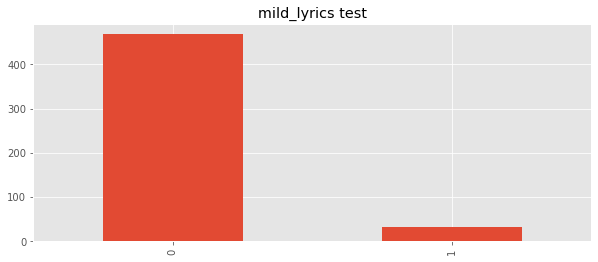

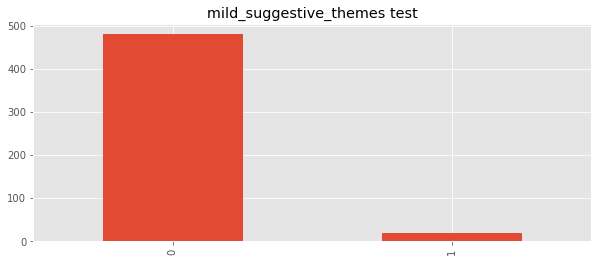

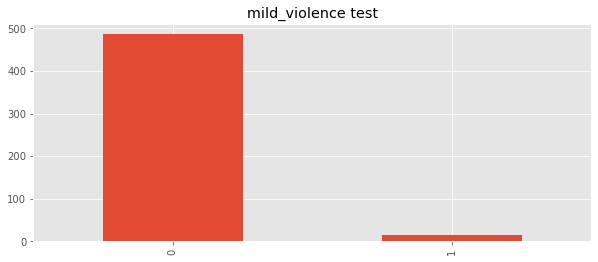

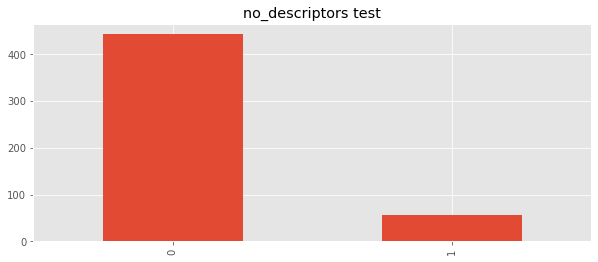

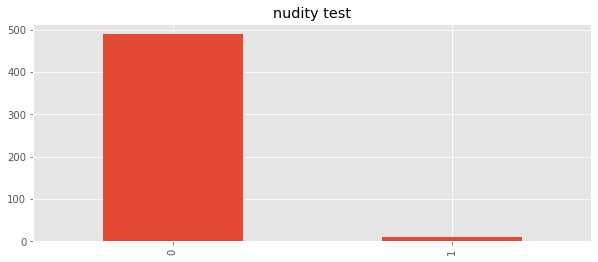

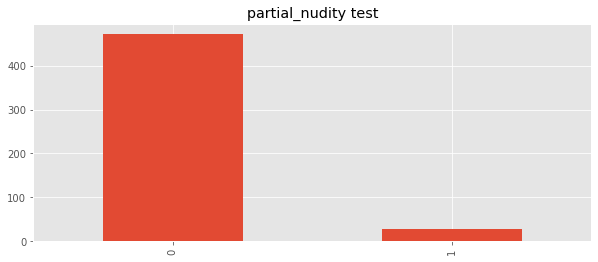

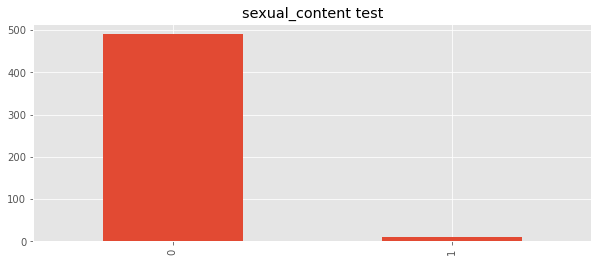

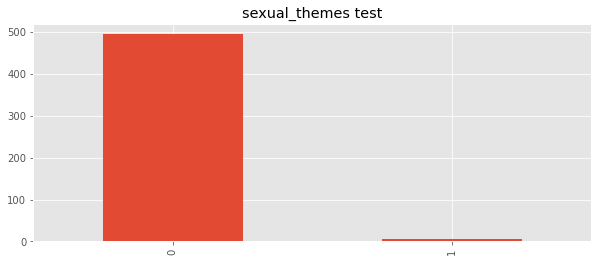

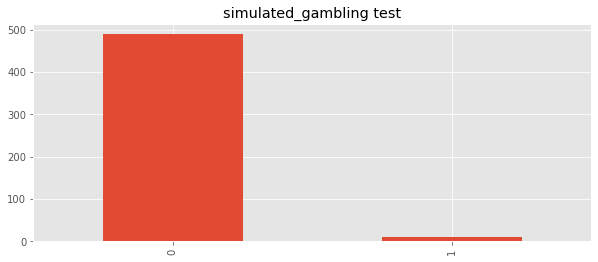

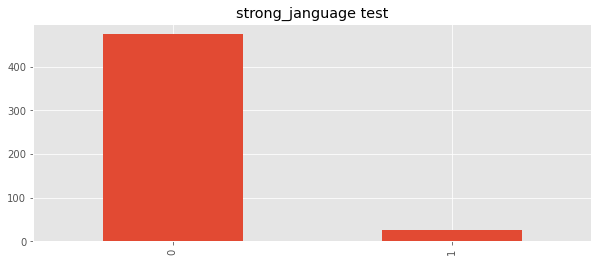

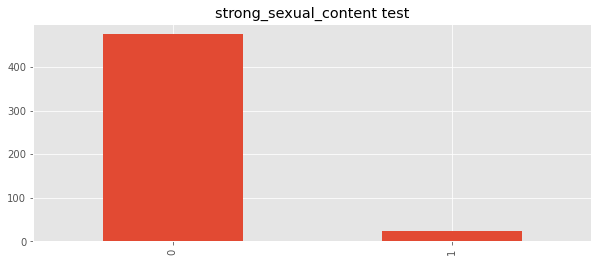

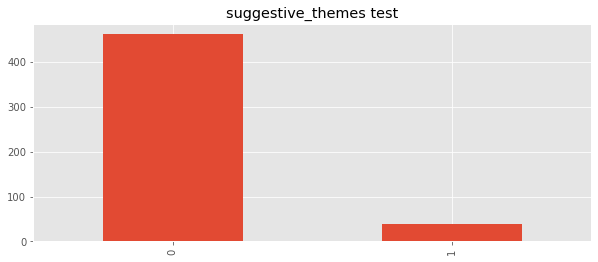

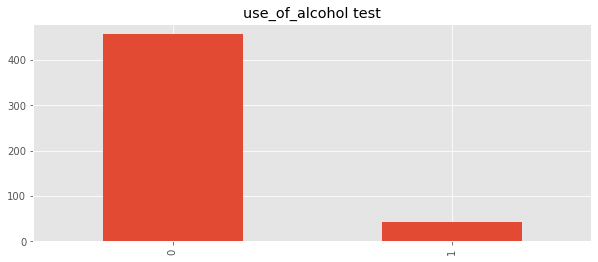

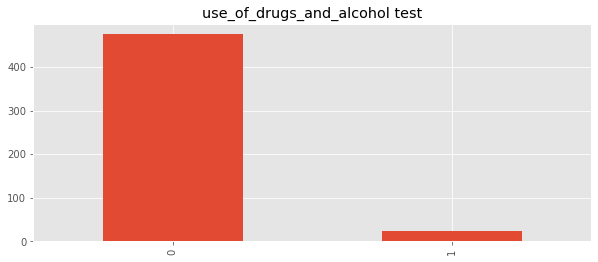

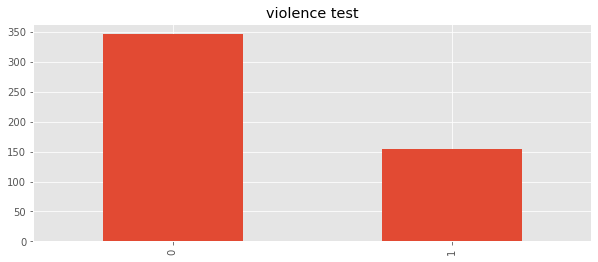

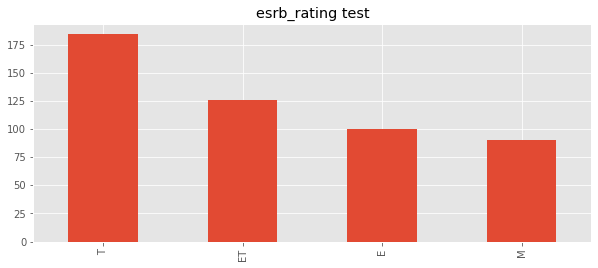

In [6]:
colTest = esrbTest.columns #Load the testing set's columns

#For each column, plot the values for a quick visualization
for col in colTest:
    #Ignore the title column
    if col != "title":
        plt.figure() #Reload the figure to have items on separate plots
        esrbTest[col].value_counts().plot.bar(title = col + " test") #Plot the columns

The test set looks to have similar proportions, to the training set, but there is a heavy skew toward blood and violence. This may give some difficulty to a classification algorithm. Everything else seems like it will be fine.

---

# Prepare the Data for Classification

## Create a Validation Set

In [7]:
ratings = esrbTrain["esrb_rating"].copy() #Get the ratings into their own variable
rates = pd.get_dummies(ratings) #Encode the ESRB ratings
print(rates[:5]) #Show how the data is encoded

#Drop ratings and titles from the characteristics. We are testing on rating and the title only adds processing time and dummies
characteristics = esrbTrain.drop(columns = {"title", "esrb_rating"}).copy()
trainChara, valChara, trainRating, valRating = train_test_split(characteristics, rates, test_size = 0.25) #Split out a validation set

   E  ET  M  T
0  1   0  0  0
1  0   1  0  0
2  0   0  1  0
3  0   1  0  0
4  0   0  0  1


## Set Up the Test Set

In [8]:
testRate = esrbTest["esrb_rating"].copy() #Get the ratings
testTitles = esrbTest["title"] #Extract the titles for later
testChara = esrbTest.drop(columns = {"title", "esrb_rating"}).copy() #Drop the title from the test set for consistency
testChara.head() #Take a peek at the data

,console,alcohol_reference,animated_blood,blood,blood_and_gore,cartoon_violence,crude_humor,drug_reference,fantasy_violence,intense_violence,...,partial_nudity,sexual_content,sexual_themes,simulated_gambling,strong_janguage,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


---

# Build the Model

Build and test based on the validation set. The test data will be used for classification and not verification in this case.

In [9]:
#GetChara: Get the most important characteristics to the classification
#Input: the characteristics, the model, what the dataset pertains to
#Output: None
def getChara(characteristics, forest, subject):
    attributes = characteristics.columns #Get the tested attributes
    attributes = list(zip(attributes, forest.feature_importances_)) #Zip the attributes together with their coefficient
    sortAtt = sorted(attributes, key = lambda x: x[1], reverse = True) #Sort the zipped attributes by their coefficients

    print("According to the Random Forest, the most important factors for {} are: ".format(subject)) #Start printing the most important labels
    i = 0 #Counter variable so only the top five are printed

    #For each attribute in the sorted attributes
    for label, coef in sortAtt:
        if i < 7: #If there has not been five printed yet
            print(label) #Print the label as an important factor
        i += 1 #Increase i by 1
        
#ReportClassification: analyze accuracy based on the validation set
#Input: The model, the validation metrics, and the labels
#Output: Classification metrics
def reportClassification(forest, charaVal, rateVal, labels):
    predict = forest.predict(charaVal) #Create predictions off the validation set
    accuracy = forest.score(charaVal, rateVal) #Get the accuracy of the validation
    error = np.sqrt(mean_squared_error(rateVal, predict)) #Get the root mean square error
    report = classification_report(rateVal, predict, target_names = labels) #Get the classification report
    
    return accuracy, error, report #Return the classification metrics
        
#BuildModel: Build a random forest model based on the split values
#Input: The train_test_split training results
#Output: the trained model
def buildModel(charaTrain, rateTrain):
    forest = RandomForestClassifier(n_estimators = 100) #Initialize the forest model
    forest.fit(charaTrain, rateTrain) #Train the model
    return forest #Return the model

In [10]:
model = buildModel(trainChara, trainRating) #Build the forest model

In [11]:
labels = ratings.unique() #Get the ESRB ratings

acc, err, rep = reportClassification(model, valChara, valRating, labels) #Get the classification reports
print("Accuracy: {}".format(acc)) #Print the accuracy
print("Root Mean Square Error: {}".format(err)) #Print the error
print("Classification Report\n: {}".format(rep)) #Print the classification report

Accuracy: 0.8333333333333334
Root Mean Square Error: 0.2707623243490863
Classification Report
:               precision    recall  f1-score   support

           E       0.93      0.95      0.94       108
          ET       0.83      0.78      0.80       104
           M       0.89      0.86      0.88        98
           T       0.84      0.77      0.80       164

   micro avg       0.87      0.83      0.85       474
   macro avg       0.87      0.84      0.86       474
weighted avg       0.87      0.83      0.85       474
 samples avg       0.83      0.83      0.83       474



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


I tested the validation with various split sizes. The accuracy was highest with a lower validation split, but higher splits lead to a higher recall. The recall is more important in a case like this, so I will stick with a 25% validation split. 

E and M are the best accounted for despite their smaller sizes, meaning they are likely more clearly defined when it comes to characteristics to make a game E or M. E10+ and T must has more nuance and human error, hence the lower rates despite their high counts.

In [12]:
getChara(characteristics, model, "ESRB Rating") #Get the most important characteristics

According to the Random Forest, the most important factors for ESRB Rating are: 
no_descriptors
strong_janguage
blood
fantasy_violence
blood_and_gore
mild_fantasy_violence
suggestive_themes


It appears violence, language, blood, and themes are the most important attributes in classifying ESRB Ratings. No descriptors means that a game did not get any of the other descriptors, meaning it has no problem content. This likely applies to giving a more family friendly rating like E, hence its importance. 

---

# Test the Model

In [13]:
predict = model.predict(testChara) #Create predictions off the test set
rate = [] #Create a list to hold converted predictions

#For each prediction, translate it into ESRB Ratings
for pre in predict:
    #Try to get a value from the predictions
    try:
        #Take the predictions and multiply the labels to make unused ones null. Then filter out the new nulls to leave
        #    a single rating. Then convert that into a list to be able to extract the values. Finally, get the only value.
        rate.append(list(filter(None, pre * labels))[0])
        
    #Add the most common item if the model did not predict anything
    except:
        rate.append("T") #Give the most common value
        
corr = (rate == testRate) #Compare the ratings to see where it was correct
comp = {"Title" : testTitles, "Predicted" : rate, "Actual" : testRate, "Correct": corr} #Build a dictionary for the ratings and correctness lists
    
test = pd.DataFrame(comp) #Put the dictionary into a pandas dataframe. This could be converted into a further CSV from here. 
test.head() #Take a peek at the dataframe

,Title,Predicted,Actual,Correct
0,Still Time,T,T,True
1,Surf World Series,E,E,True
2,The Metronomicon: Slay the Dance Floor,T,T,True
3,Windjammers,E,E,True
4,Rock of Ages 2: Bigger and Boulder,ET,ET,True


In [14]:
print(test["Correct"].value_counts() / len(test)) #Check the amount correct

True     0.846
False    0.154
Name: Correct, dtype: float64


In [15]:
print(test.loc[test["Title"] == "Yooka-Laylee"]) #Print Yooka-Laylee as an example of how this could be searchable in a program

            Title Predicted Actual  Correct
276  Yooka-Laylee        ET     ET     True


I had gone into this assuming the test set did not have the ratings, so the validation step was not inherently necessary. I would have just seen what it predicted without confirmation if it actually did not have the ratings. The way I did it still makes a visual representation of what it got right and wrong, which is interesting in itself. The main issues I am seeing are ones that were classified as one off of the actual rating, which could be the ESRB's humans causing some variance.

I have let the full dataset load below so you can go through it (if desired). I saved it for the end as to not bog down the rest of the content.

In [16]:
pd.set_option("display.max_rows", None, "display.max_columns", None) #Disable limits
test #Load the full dataset

,Title,Predicted,Actual,Correct
0,Still Time,T,T,True
1,Surf World Series,E,E,True
2,The Metronomicon: Slay the Dance Floor,T,T,True
3,Windjammers,E,E,True
4,Rock of Ages 2: Bigger and Boulder,ET,ET,True
5,South Park: The Fractured but Whole,M,M,True
6,Dishonored: Death of the Outsider,M,M,True
7,Battle of the Bulge,ET,ET,True
8,F1 2017,E,E,True
9,NARUTO SHIPPUDEN™: Ultimate Ninja® STORM 2,T,T,True
